In [23]:
%matplotlib inline

from __future__ import division, print_function, unicode_literals

import os
import scipy.io.arff as arff
import numpy as np
import matplotlib.pyplot as plt

os.chdir('/media/Data/Research Data/Evolving ES data/')
fname = 'bruteforce_{}_f{}.arff'
cases = {dim: {} for dim in [2, 3, 5, 10, 20]}

for dim in [2, 3, 5, 10, 20]:
    for fid in range(1, 25):
        case = arff.loadarff('arff_files/' + fname.format(dim, fid))[0]
        case = np.array([list(dat) for dat in case])
        cases[dim][fid] = case

min_column = [0] * 2304
min_column.extend(range(1,2305))
max_column = range(1, 2305)
max_column.extend([2304] * 2304)
min_column = np.array(min_column)
max_column = np.array(max_column)

min_column = min_column.reshape((4608,1))
max_column = max_column.reshape((4608,1))
np.repeat(min_column, 11, axis=0)
np.repeat(min_column, 11, axis=1)
min_columns = np.repeat(min_column, 11, axis=1)
max_columns = np.repeat(max_column, 11, axis=1)

dists = max_columns - min_columns
dists[-1,:] = 1

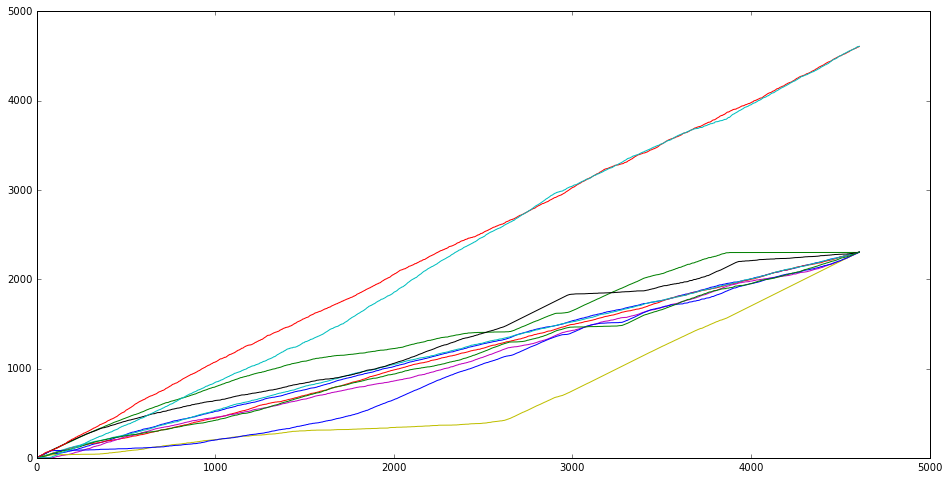

In [39]:
plt.figure(figsize=(16, 8))
plt.plot(np.cumsum(cases[2][1][cases[2][1][:,11].argsort()][:,:11], axis=0))
plt.show()

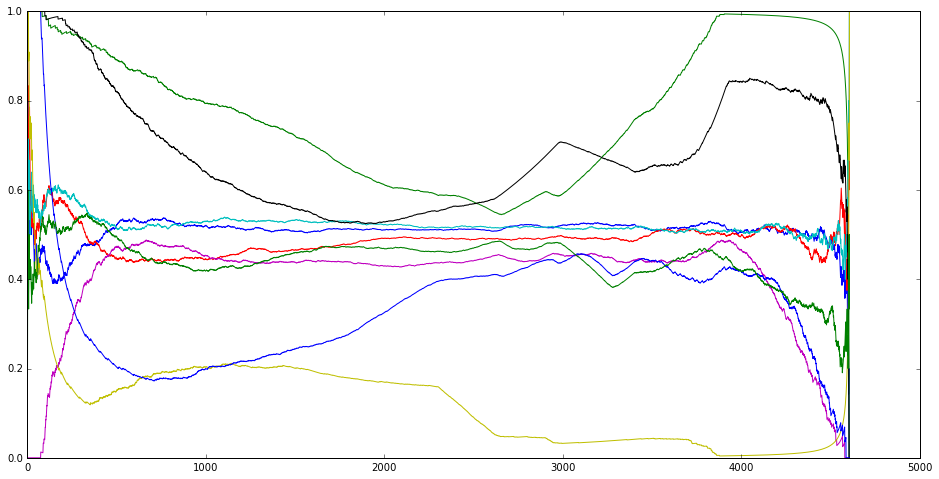

In [38]:
temp = np.cumsum(cases[2][1][ cases[2][1][:,11].argsort() ][:,:11], axis=0)
temp = temp - min_columns
temp = temp / dists

plt.figure(figsize=(16, 8))
plt.plot(temp[:-2,:9])
plt.show()